In [1]:
import numpy as np
from libsvm.svmutil import svm_problem, svm_parameter, svm_train, svm_save_model
from discrete_wavelet_transform import dwt_2d
from local_binary_pattern import lbp
from feature_fusion import concatenate_lbp_dwt
import time
import os
import matplotlib.pyplot as plt
import cv2

Import Functions from train.py

In [2]:
from train import get_data, spatial_frequency_feature_fusion, prepare_data, train_model, visualize

Run this for preprocessing

- must include /utils
- example path: "/Users/Danniel/Detection-of-GAN-Generated-Images-using-Spatial-Frequency-Domain-Fusion-Data/utils"

In [11]:
import sys
# path of the folder "Detection-of-GAN-Generated-Images-using-Spatial-Frequency-Domain-Fusion-Data"
sys.path.append("/Users/Danniel/Detection-of-GAN-Generated-Images-using-Spatial-Frequency-Domain-Fusion-Data/utils")

from preprocessing_save import load_image, save_image

# directory for reading
img_real = "/Users/Danniel/Downloads/Try/Real"
img_gan = "/Users/Danniel/Downloads/Try/GAN"

# directory for saving (must be an empty folder)
save_dir_real = "/Users/Danniel/Downloads/Try/Preprocessed_Real"
save_dir_gan = "/Users/Danniel/Downloads/Try/Preprocessed_GAN"

# store the images
image_real = load_image(img_real)
image_gan = load_image(img_gan)

save_image(image_real, save_dir_real)
save_image(image_gan, save_dir_gan)



Image is already in 512x512



Applying Gaussian Noise Reduction

1 finished



Image is already in 512x512



Applying Gaussian Noise Reduction

2 finished



Image is already in 512x512



Applying Gaussian Noise Reduction

3 finished



Image is already in 512x512



Applying Gaussian Noise Reduction

4 finished



Image is already in 512x512



Applying Gaussian Noise Reduction

5 finished



Image is already in 512x512



Applying Gaussian Noise Reduction

6 finished



Image is already in 512x512



Applying Gaussian Noise Reduction

7 finished



Image is already in 512x512



Applying Gaussian Noise Reduction

8 finished



Image is already in 512x512



Applying Gaussian Noise Reduction

9 finished



Image is already in 512x512



Applying Gaussian Noise Reduction

10 finished



Image is already in 512x512



Applying Gaussian Noise Reduction

11 finished



Image is already in 512x512



Applying Gaussian Noise Reduction

12 finished



Image is already in 512x512



Appl

Provide directory for Preprocessed Real and GAN-Generated Images

In [12]:
real_directory = "/Users/Danniel/Downloads/Try/Preprocessed_Real"
gan_directory = "/Users/Danniel/Downloads/Try/Preprocessed_GAN"

"get_data" function will load the preprocessed images from the directory and store it in a list

In [13]:
# run data preparation
real_data = get_data(real_directory)
gan_data = get_data(gan_directory)

Preprocessed Images:  50
Preprocessed Images:  50


Run to perform the proposed "spatial frequency feature fusion" method to extract meaningful features of an image to classify whether it is GAN-Generated or Real. The feature vector of each image will be stored in "fused_features" list

In [14]:
# run feature extraction & feature fusion
extracted_real = spatial_frequency_feature_fusion(real_data)
extracted_gan = spatial_frequency_feature_fusion(gan_data)

Performing Feature Extraction
Applying Local Binary Pattern



[[  0   0   0 ...   0   0   0]
 [  0 255 255 ... 255 255   0]
 [  0 255 255 ... 255 255   0]
 ...
 [  0  30  50 ... 251 249   0]
 [  0  30  56 ... 249  56   0]
 [  0   0   0 ...   0   0   0]]

1 out of 100 images
Percentage: 1.0




[[  0   0   0 ...   0   0   0]
 [  0 224 227 ... 243 255   0]
 [  0 227 195 ... 235 201   0]
 ...
 [  0 252 124 ... 121 248   0]
 [  0 120 252 ...  56 120   0]
 [  0   0   0 ...   0   0   0]]

2 out of 100 images
Percentage: 2.0




[[  0   0   0 ...   0   0   0]
 [  0 255 255 ... 255 251   0]
 [  0 255 239 ... 255 255   0]
 ...
 [  0 128 134 ... 135 207   0]
 [  0 135 199 ... 199 255   0]
 [  0   0   0 ...   0   0   0]]

3 out of 100 images
Percentage: 3.0




[[  0   0   0 ...   0   0   0]
 [  0 255 255 ... 239 207   0]
 [  0 255 124 ... 199 255   0]
 ...
 [  0 255 255 ... 131 255   0]
 [  0 249 236 ... 255 255   0]
 [  0   0   0 ...   0   0   0]]

4 out of 100 images
Percentage: 4.0




[[  0

In [14]:
# for multi-tasking
import asyncio

async def feature_extraction(images):
    await asyncio.sleep(1)
    fused_features = spatial_frequency_feature_fusion(images)

    return fused_features

async def main():
    extracted_real = asyncio.create_task(feature_extraction(real_data))
    extracted_gan = asyncio.create_task(feature_extraction(gan_data))

    e_real = await extracted_real
    e_gan = await extracted_gan

    return e_real, e_gan
   

real, gan = await main()


Performing Feature Extraction
Applying Local Binary Pattern



[[  0   0   0 ...   0   0   0]
 [  0 236 206 ... 240 240   0]
 [  0 199 207 ... 240 240   0]
 ...
 [  0  62  60 ...   6 135   0]
 [  0  30  60 ... 199 199   0]
 [  0   0   0 ...   0   0   0]]

1 out of 50 images
Percentage: 2.0




[[  0   0   0 ...   0   0   0]
 [  0 127 255 ... 252 254   0]
 [  0 254 124 ... 224 255   0]
 ...
 [  0 248 120 ... 120 120   0]
 [  0 248 248 ...  96 238   0]
 [  0   0   0 ...   0   0   0]]

2 out of 50 images
Percentage: 4.0




[[  0   0   0 ...   0   0   0]
 [  0 131 227 ... 255 255   0]
 [  0 143 131 ... 255 255   0]
 ...
 [  0 247 255 ... 223  30   0]
 [  0 139 133 ... 223  30   0]
 [  0   0   0 ...   0   0   0]]

3 out of 50 images
Percentage: 6.0




[[  0   0   0 ...   0   0   0]
 [  0 239 195 ... 252 126   0]
 [  0 231 231 ...  60  60   0]
 ...
 [  0 255 255 ... 211 255   0]
 [  0 248 252 ... 255  57   0]
 [  0   0   0 ...   0   0   0]]

4 out of 50 images
Percentage: 8.0




[[  0   0

For Data Visualization
- provide real and gan parameter

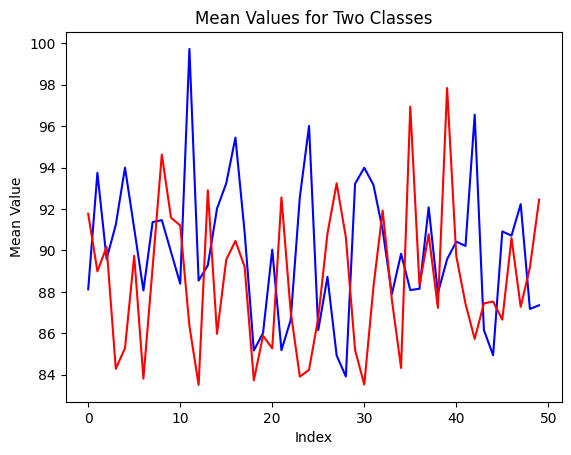

([88.11944961547852,
  93.74908638000488,
  89.58716773986816,
  91.24160385131836,
  93.9985523223877,
  91.05903053283691,
  88.06630516052246,
  91.36682891845703,
  91.46381568908691,
  89.9283275604248,
  88.39180946350098,
  99.73212432861328,
  88.54463958740234,
  89.27888870239258,
  92.0257797241211,
  93.23738098144531,
  95.45002174377441,
  90.8724365234375,
  85.16546249389648,
  86.00954627990723,
  90.03616142272949,
  85.17818832397461,
  86.63264083862305,
  92.57834243774414,
  96.0146312713623,
  86.15224266052246,
  88.72264099121094,
  84.92535591125488,
  83.91093635559082,
  93.21469116210938,
  93.99202156066895,
  93.16333961486816,
  90.98285102844238,
  87.8865909576416,
  89.8358325958252,
  88.08440017700195,
  88.14871597290039,
  92.08411598205566,
  87.93324661254883,
  89.57538986206055,
  90.42439270019531,
  90.21597862243652,
  96.55365943908691,
  86.15398788452148,
  84.93636703491211,
  90.91703033447266,
  90.71243095397949,
  92.23371124267578,

In [15]:
# visualize
visualize(real, gan)

Data Preparation before feeding to the classifier
- assigning of labels
- flattening of feature vector

In [16]:
# prepare the data
labels, datasets = prepare_data(real, gan)
print(labels, datasets)

----------------------------Preparing the Data-------------------------------

Labels:  100
Datasets:  100
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.] [array([0, 0, 0, ..., 0, 0, 0], dtype=uint8), array([0, 0, 0, ..., 0, 0, 0], dtype=uint8), array([0, 0, 0, ..., 0, 0, 0], dtype=uint8), array([0, 0, 0, ..., 0, 0, 0], dtype=uint8), array([0, 0, 0, ..., 0, 0, 0], dtype=uint8), array([0, 0, 0, ..., 0, 0, 0], dtype=uint8), array([  0,   0,   0, ...,  32,  95, 127], dtype=uint8), array([ 0,  0,  0, ..., 97, 32,  0], dtype=uint8), array([0, 0, 0, ..., 0, 0, 0], dtype=uint8), array([0, 0, 0, ..., 0, 0, 0], dtype=uint8), array([0, 0, 0, ..., 0, 0, 0], dtype=uint8), array([0, 0, 0, ..., 0, 0, 0], dtype=uint8), array([0, 0, 0, ..., 0, 0, 0

Model Training
- Support Vector Machine
- Linear Kernel

In [17]:
# train the data
model = train_model(labels, datasets )

----------------------Model Training--------------------------

Cross Validation Accuracy = 83%
83.0


Save the model using ".model" extension

In [10]:
# save the model
model_file = "/Users/Danniel/Downloads/faces_try(preprocessed).model"
svm_save_model(model_file, model)

Model Testing
- provide directory (folder) for testing datasets



Image is already in 512x512



Applying Gaussian Noise Reduction
Performing Feature Extraction
Applying Local Binary Pattern



[[  0   0   0 ...   0   0   0]
 [  0 225 243 ... 120 248   0]
 [  0 131 251 ... 248 248   0]
 ...
 [  0 225 207 ... 195 227   0]
 [  0 225 231 ... 195 243   0]
 [  0   0   0 ...   0   0   0]]

1 out of 1 images
Percentage: 100.0


LBP application finished


Applying DWT to Images



[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

1 out of 1 images
Percentage: 100.0


DWT application finished



1 out of 1 images
Percentage: 100.0



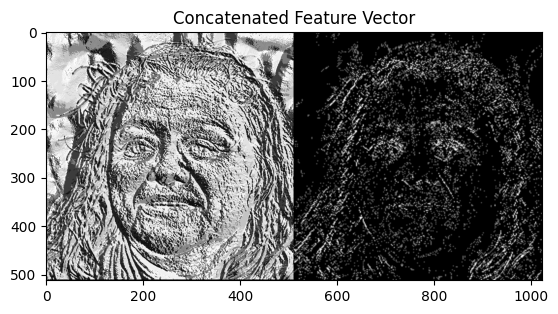

[[  0   0   0 ...   0   0   0]
 [  0 225 243 ...   0   0   0]
 [  0 131 251 ...   0   0   0]
 ...
 [  0 225 207 ...   0   0   0]
 [  0 225 231 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)]


-------------------THE MODEL IS PREDICTING----------------------------

Accuracy = 100% (1/1) (classification)
------------------------------------------RESULT-----------------------------------



TypeError: unsupported format string passed to list.__format__

In [12]:
from libsvm.svmutil import svm_problem, svm_train, svm_save_model, svm_load_model, svm_predict
from preprocessing import preprocessing
import os
import numpy as np
from train import spatial_frequency_feature_fusion

# test the model
def predict(directory):
    images = []

    # load the images and store in images list
    for filename in os.listdir(directory):
        image = os.path.join(directory, filename)
        if image is not None:
            images.append(image)
      


    # load the model
    model_file = "/Users/Danniel/Downloads/faces_validate.model"
    loaded_model = svm_load_model(model_file)

    # preprocessing
    preprocessed_img = []
    for i in images:
        preprocessed_img.append(preprocessing(i))   

    # flatten the feature vector
    fused_features = spatial_frequency_feature_fusion(preprocessed_img)
    labels = np.ones((len(fused_features), 1)) 
    true_label = labels.reshape(labels.shape[0])

    feature_vector = []
    for i in fused_features:
        print(i)
        feature_vector.append(i.flatten())

    print(feature_vector)



    # predict the result
    print("\n\n-------------------THE MODEL IS PREDICTING----------------------------\n")
    predicted_labels, _, likelihood = svm_predict(true_label, feature_vector, loaded_model, '-b 1')


    print("------------------------------------------RESULT-----------------------------------\n")
    result = []
    for i in predicted_labels:
        if i == 1.0:
            result.append("Real")
        elif i == 0.0:
            result.append("GAN")

    
    # formatted_likelihoods = []
    # for l in likelihood:
    #     formatted_likelihoods.append("{:.2f}".format(l))        

    print(likelihood)
    print(result)

    # for index, l, r in zip(range(len(likelihood)), likelihood, result):
        
        

    #     print(f"{index}: {likelihood}")
    #     print(r)

#provide directory for testing dataset
dir = "/Users/Danniel/Downloads/Low Dataset/test_combination"

predict(dir)

# existing_model_file = "/Users/Danniel/Downloads/sample.model"
# existing_model = svm_load_model(existing_model_file)

# # New data
# new_labels = np.array(new_labels)
# new_datasets = np.array(new_datasets)

# # Train or update the model incrementally
# updated_model = train_model(existing_model, new_labels, new_datasets)

# # Save the updated model
# model_file = "/Users/Danniel/Downloads/updated_model.model"
# svm_save_model(model_file, updated_model)

# # Use the updated model for prediction
# image_directory = "/Users/Danniel/Downloads/Low Dataset/test"
# images = [os.path.join(image_directory, filename) for filename in os.listdir(image_directory)]
# predict(updated_model, images)